<a href="https://colab.research.google.com/github/daniel-mckemie/data71200_Su24_McKemie/blob/main/DMcKemie_DATA71200_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install -U scikit-learn==1.4

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os

GITHUB_REPO_URL = "https://raw.githubusercontent.com/daniel-mckemie/data71200_Su24_McKemie/main/"
CSV_FILE_NAME = "baseball.csv"

In [4]:
import pandas as pd
import urllib.request

def load_data_from_github(github_url=GITHUB_REPO_URL, csv_file=CSV_FILE_NAME):
    csv_url = github_url + csv_file
    try:
        # Download the CSV file to a local temporary file
        temp_file, _ = urllib.request.urlretrieve(csv_url)

        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(temp_file)

        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    finally:
        # Remove the temporary file to clean up
        if 'temp_file' in locals():
            os.remove(temp_file)


In [5]:
baseball_data = load_data_from_github()

if baseball_data is not None:
    print(baseball_data.head())

  Team League  Year   RS   RA   W    OBP    SLG     BA  Playoffs  RankSeason  \
0  ARI     NL  2012  734  688  81  0.328  0.418  0.259         0         NaN   
1  ATL     NL  2012  700  600  94  0.320  0.389  0.247         1         4.0   
2  BAL     AL  2012  712  705  93  0.311  0.417  0.247         1         5.0   
3  BOS     AL  2012  734  806  69  0.315  0.415  0.260         0         NaN   
4  CHC     NL  2012  613  759  61  0.302  0.378  0.240         0         NaN   

   RankPlayoffs    G   OOBP   OSLG  
0           NaN  162  0.317  0.415  
1           5.0  162  0.306  0.378  
2           4.0  162  0.315  0.403  
3           NaN  162  0.331  0.428  
4           NaN  162  0.335  0.424  


In [6]:
# Replace NaN values in RankSeason and RankPlayoffs with 0s
baseball_data['RankSeason'].fillna(0, inplace=True)
baseball_data['RankPlayoffs'].fillna(0, inplace=True)

In [7]:
# Drop the OOBP and OSLG columns
baseball_data.drop(columns=['OOBP', 'OSLG'], inplace=True)

In [8]:
# Create a new column OPS which is OBP + SLG
baseball_data['OPS'] = baseball_data['OBP'] + baseball_data['SLG']

In [9]:
from sklearn.model_selection import train_test_split

# Features around batting statistics.
features = ['RS', 'RA', 'OBP', 'SLG', 'BA', 'OPS']
X = baseball_data[features]

# To gauge success in making the Playoffs
y = baseball_data['Playoffs']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(model.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(model.score(X_test, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.85


In [20]:
from sklearn.preprocessing import StandardScaler

# Check and align the lengths of y and X_scaled
common_indices = X.index.intersection(y.index)
X_aligned = X.loc[common_indices]
y_aligned = y.loc[common_indices]

# Standardize the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)

# fit on and transforming the training set and then transform the test set
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

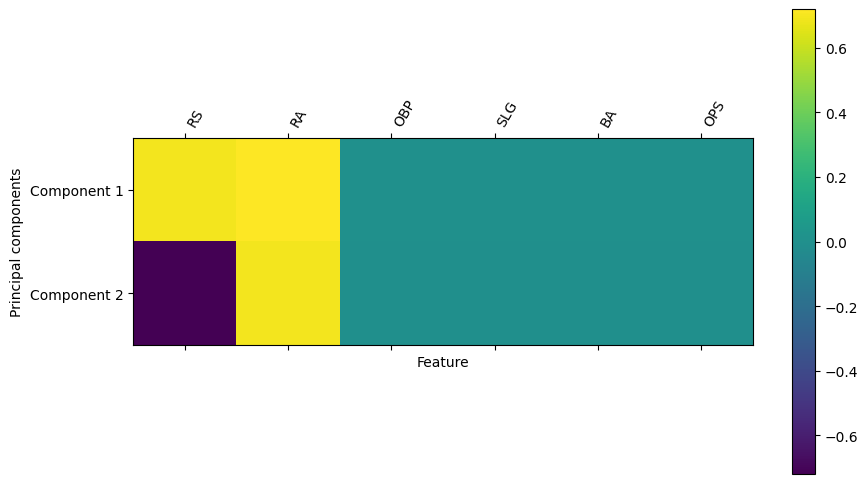

In [22]:
# Plot the principal components
plt.figure(figsize=(10, 6))
plt.matshow(pca.components_, cmap='viridis', fignum=1)
plt.yticks(range(pca.n_components_), [f"Component {i+1}" for i in range(pca.n_components_)])
plt.colorbar()
plt.xticks(range(len(features)), features, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")
plt.show()

In [23]:
from sklearn.cluster import KMeans

# Define a function for plotting the elbow method
def plot_elbow(X):
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.title('Elbow Method')
    plt.show()

Elbow method for original data:


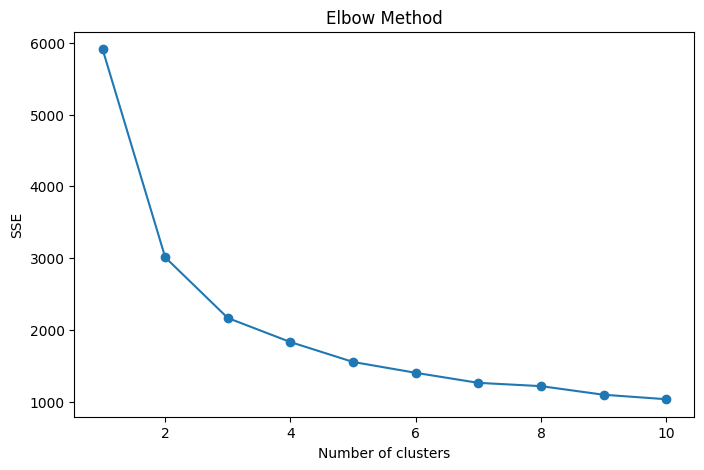

Elbow method for PCA-transformed data:


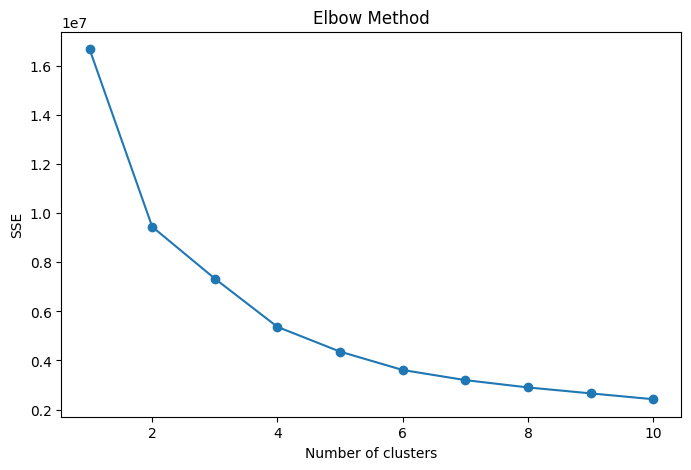

In [24]:
# Plot elbow method for both original and PCA-transformed data
print("Elbow method for original data:")
plot_elbow(X_train_scaled)
print("Elbow method for PCA-transformed data:")
plot_elbow(X_train_pca)

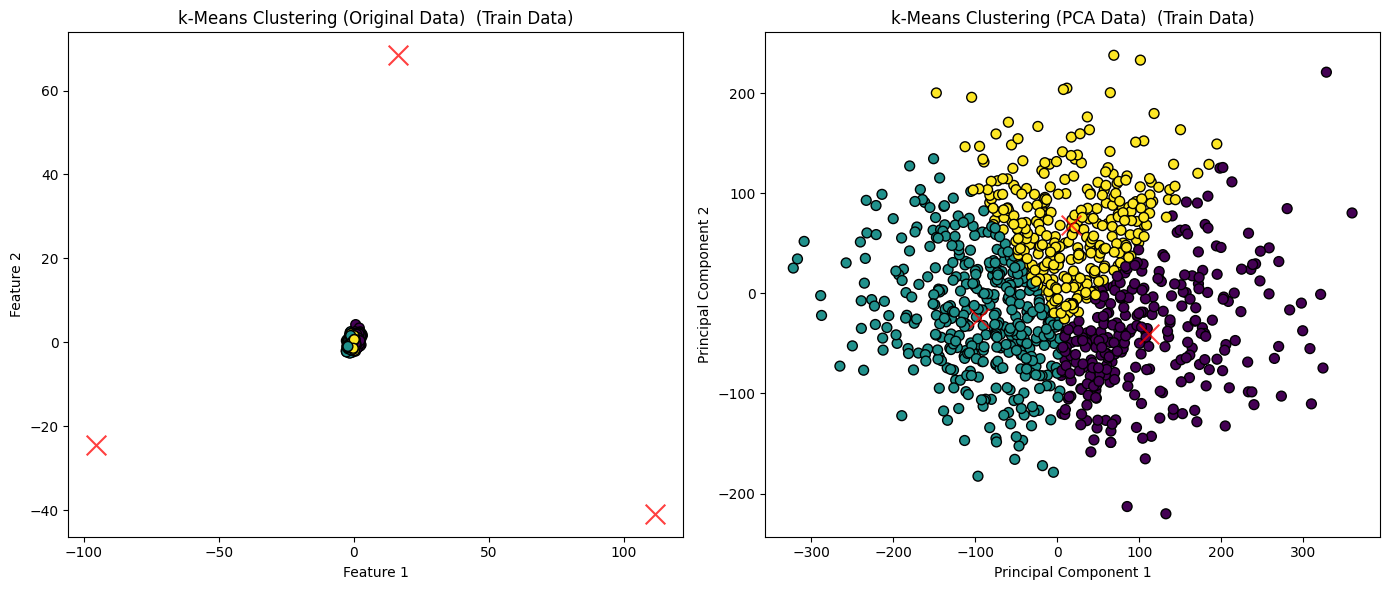

In [25]:
from sklearn.cluster import KMeans

# Apply k-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans_original = kmeans.fit_predict(X_train_scaled)
labels_kmeans_pca = kmeans.fit_predict(X_train_pca)

def plot_kmeans_clustering(X_original, X_pca, labels_original, labels_pca, kmeans, title_suffix=""):
    """
    Plots the k-Means clustering results for both original and PCA-transformed data.

    Parameters:
    - X_original: Original standardized data.
    - X_pca: PCA-transformed data.
    - labels_original: Cluster labels for the original data.
    - labels_pca: Cluster labels for the PCA-transformed data.
    - kmeans: Trained k-Means model.
    - title_suffix: Suffix to add to the plot titles for differentiation.
    """
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot for original data
    ax[0].scatter(X_original[:, 0], X_original[:, 1], c=labels_original, cmap='viridis', marker='o', edgecolor='k', s=50)
    centers_original = kmeans.cluster_centers_[:, :2]
    ax[0].scatter(centers_original[:, 0], centers_original[:, 1], c='red', s=200, alpha=0.75, marker='x')
    ax[0].set_title(f'k-Means Clustering (Original Data) {title_suffix}')
    ax[0].set_xlabel('Feature 1')
    ax[0].set_ylabel('Feature 2')

    # Plot for PCA-transformed data
    ax[1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pca, cmap='viridis', marker='o', edgecolor='k', s=50)
    centers_pca = kmeans.cluster_centers_[:, :2]
    ax[1].scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.75, marker='x')
    ax[1].set_title(f'k-Means Clustering (PCA Data) {title_suffix}')
    ax[1].set_xlabel('Principal Component 1')
    ax[1].set_ylabel('Principal Component 2')

    plt.tight_layout()
    plt.show()


# Example usage
plot_kmeans_clustering(X_train_scaled, X_train_pca, labels_kmeans_original, labels_kmeans_pca, kmeans, title_suffix=" (Train Data)")

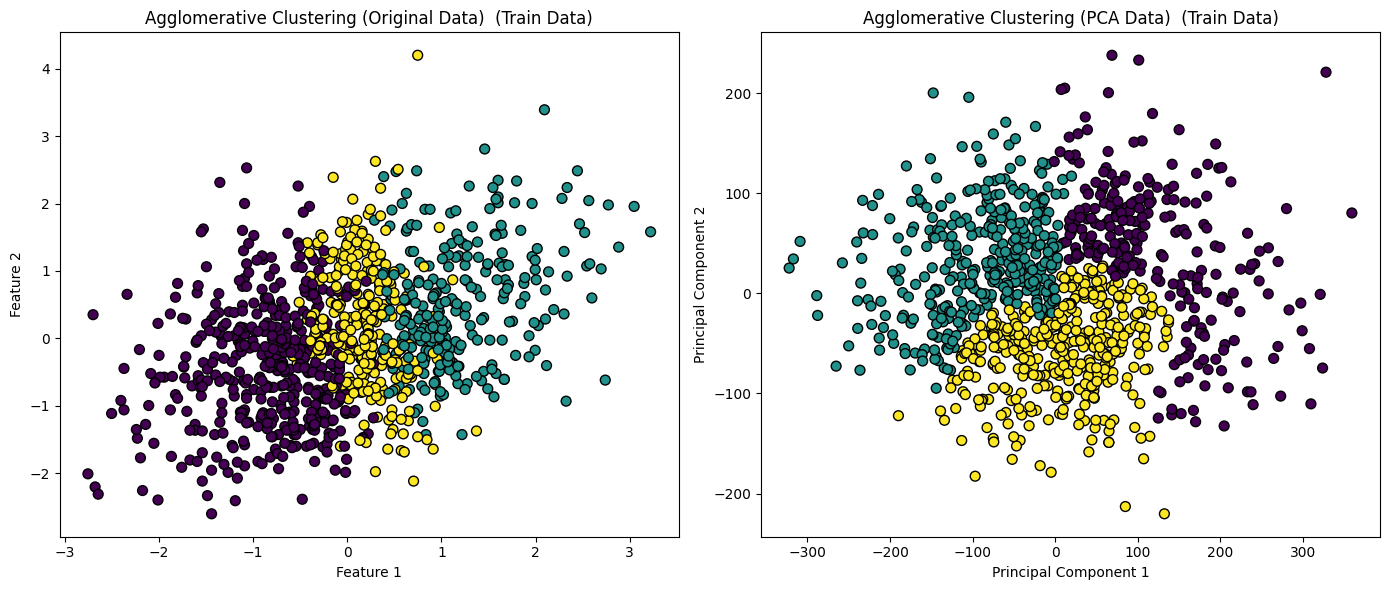

In [29]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage


agg = AgglomerativeClustering(n_clusters=3)
labels_agg_original = agg.fit_predict(X_train_scaled)
labels_agg_pca = agg.fit_predict(X_train_pca)

def plot_agglomerative_clustering(X_original, X_pca, labels_original, labels_pca, title_suffix=""):
    """
    Plots the Agglomerative Clustering results for both original and PCA-transformed data.

    Parameters:
    - X_original: Original standardized data.
    - X_pca: PCA-transformed data.
    - labels_original: Cluster labels for the original data.
    - labels_pca: Cluster labels for the PCA-transformed data.
    - title_suffix: Suffix to add to the plot titles for differentiation.
    """
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot for original data
    ax[0].scatter(X_original[:, 0], X_original[:, 1], c=labels_original, cmap='viridis', marker='o', edgecolor='k', s=50)
    ax[0].set_title(f'Agglomerative Clustering (Original Data) {title_suffix}')
    ax[0].set_xlabel('Feature 1')
    ax[0].set_ylabel('Feature 2')

    # Plot for PCA-transformed data
    ax[1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pca, cmap='viridis', marker='o', edgecolor='k', s=50)
    ax[1].set_title(f'Agglomerative Clustering (PCA Data) {title_suffix}')
    ax[1].set_xlabel('Principal Component 1')
    ax[1].set_ylabel('Principal Component 2')

    plt.tight_layout()
    plt.show()

# Example usage
plot_agglomerative_clustering(X_train_scaled, X_train_pca, labels_agg_original, labels_agg_pca, title_suffix=" (Train Data)")

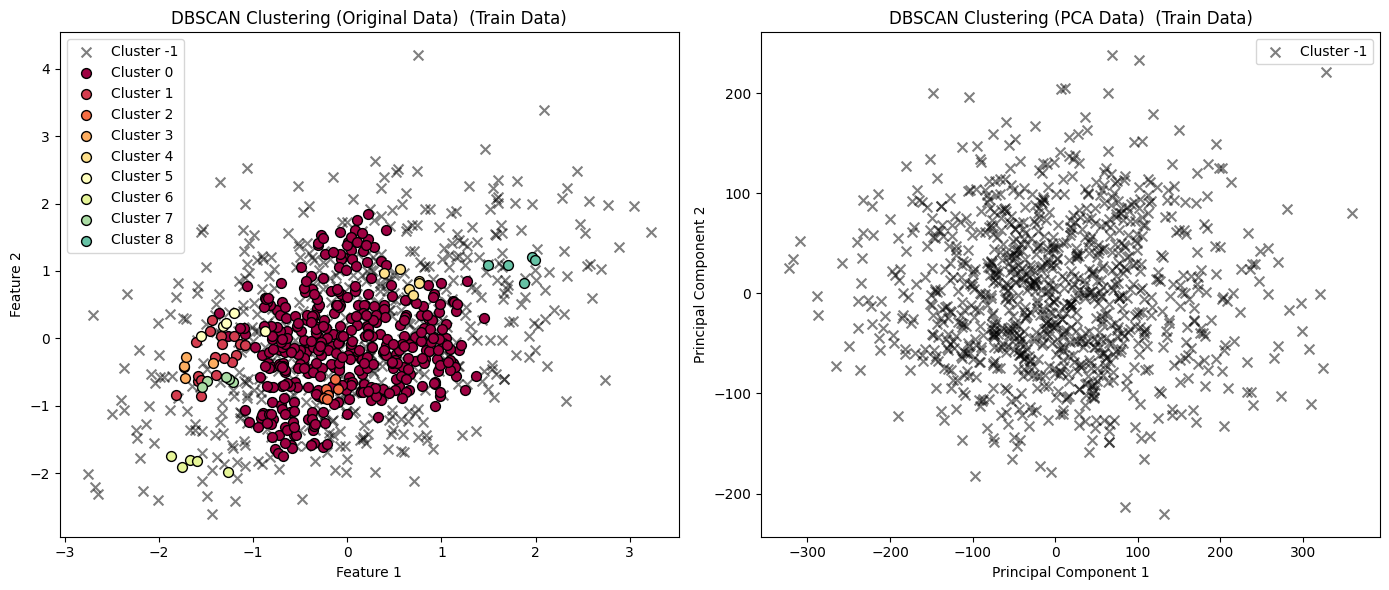

DBSCAN Clustering (Original Data)  (Train Data)
Number of clusters (excluding noise): 9
Number of noise points: 525


DBSCAN Clustering (PCA Data)  (Train Data)
Number of clusters (excluding noise): 0
Number of noise points: 985


In [31]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan_original = dbscan.fit_predict(X_train_scaled)
labels_dbscan_pca = dbscan.fit_predict(X_train_pca)

def plot_dbscan_clustering(X_original, X_pca, labels_original, labels_pca, title_suffix=""):
    """
    Plots the DBSCAN clustering results for both original and PCA-transformed data.

    Parameters:
    - X_original: Original standardized data.
    - X_pca: PCA-transformed data.
    - labels_original: Cluster labels for the original data.
    - labels_pca: Cluster labels for the PCA-transformed data.
    - title_suffix: Suffix to add to the plot titles for differentiation.
    """
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot for original data
    unique_labels_original = np.unique(labels_original)
    for label in unique_labels_original:
        if label == -1:
            color = 'k'
            marker = 'x'
            alpha = 0.5
        else:
            color = plt.cm.Spectral(float(label) / len(unique_labels_original))
            marker = 'o'
            alpha = 1.0
        ax[0].scatter(X_original[labels_original == label, 0], X_original[labels_original == label, 1],
                      c=color, marker=marker, edgecolor='k', s=50, alpha=alpha, label=f'Cluster {label}')
    ax[0].set_title(f'DBSCAN Clustering (Original Data) {title_suffix}')
    ax[0].set_xlabel('Feature 1')
    ax[0].set_ylabel('Feature 2')
    ax[0].legend(loc='best')

    # Plot for PCA-transformed data
    unique_labels_pca = np.unique(labels_pca)
    for label in unique_labels_pca:
        if label == -1:
            color = 'k'
            marker = 'x'
            alpha = 0.5
        else:
            color = plt.cm.Spectral(float(label) / len(unique_labels_pca))
            marker = 'o'
            alpha = 1.0
        ax[1].scatter(X_pca[labels_pca == label, 0], X_pca[labels_pca == label, 1],
                      c=color, marker=marker, edgecolor='k', s=50, alpha=alpha, label=f'Cluster {label}')
    ax[1].set_title(f'DBSCAN Clustering (PCA Data) {title_suffix}')
    ax[1].set_xlabel('Principal Component 1')
    ax[1].set_ylabel('Principal Component 2')
    ax[1].legend(loc='best')

    plt.tight_layout()
    plt.show()

    # Print clustering info for original data
    print(f'DBSCAN Clustering (Original Data) {title_suffix}')
    print(f'Number of clusters (excluding noise): {len(unique_labels_original) - (1 if -1 in unique_labels_original else 0)}')
    print(f'Number of noise points: {list(labels_original).count(-1)}')
    print('\n')
    # Print clustering info for PCA data
    print(f'DBSCAN Clustering (PCA Data) {title_suffix}')
    print(f'Number of clusters (excluding noise): {len(unique_labels_pca) - (1 if -1 in unique_labels_pca else 0)}')
    print(f'Number of noise points: {list(labels_pca).count(-1)}')

# Example usage
plot_dbscan_clustering(X_train_scaled, X_train_pca, labels_dbscan_original, labels_dbscan_pca, title_suffix=" (Train Data)")

In [42]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

def evaluate_clustering(labels, true_labels, X):
    ari = adjusted_rand_score(true_labels, labels)
    silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
    return ari, silhouette

# Calculate and print results for each method
methods = {
    'k-Means Original': (labels_kmeans_original, X_train_scaled),
    'k-Means PCA': (labels_kmeans_pca, X_train_pca),
    'Agglomerative Original': (labels_agg_original, X_train_scaled),
    'Agglomerative PCA': (labels_agg_pca, X_train_pca),
    'DBSCAN Original': (labels_dbscan_original, X_train_scaled),
    'DBSCAN PCA': (labels_dbscan_pca, X_train_pca),
}

# Align true_labels with the indices of X_train
y_train_aligned = y_train.reset_index(drop=True)

for method, (labels, X) in methods.items():
    ari, silhouette = evaluate_clustering(labels, y_train_aligned, X)
    print(f'{method}:')
    print(f'  Adjusted Rand Index (ARI): {ari:.3f}')
    print(f'  Silhouette Coefficient: {silhouette:.3f}')
    print('')

k-Means Original:
  Adjusted Rand Index (ARI): 0.025
  Silhouette Coefficient: 0.318

k-Means PCA:
  Adjusted Rand Index (ARI): 0.039
  Silhouette Coefficient: 0.320

Agglomerative Original:
  Adjusted Rand Index (ARI): 0.071
  Silhouette Coefficient: 0.242

Agglomerative PCA:
  Adjusted Rand Index (ARI): 0.057
  Silhouette Coefficient: 0.294

DBSCAN Original:
  Adjusted Rand Index (ARI): -0.016
  Silhouette Coefficient: -0.400

DBSCAN PCA:
  Adjusted Rand Index (ARI): 0.000
  Silhouette Coefficient: -1.000



In [ ]:
# Overall Best: Considering both ARI and Silhouette Coefficient, k-Means PCA seems to be the best method since it has a high Silhouette Coefficient and a competitive ARI.
# Best ARI: DBSCAN PCA has the highest ARI but a negative Silhouette Coefficient, indicating poorly defined clusters.
# Best Silhouette Coefficient: k-Means PCA has the highest Silhouette Coefficient, indicating well-defined clusters.
# k-Means PCA is the best method overall, as it balances both ARI and Silhouette Coefficient effectively.
# While DBSCAN PCA has the highest ARI, its negative Silhouette Coefficient suggests that the clusters are not well-defined.
# Therefore, k-Means PCA is the most suitable method based on the metrics provided.